## Helper Methods
- Tools we may use later for data pre-processing and graphing

In [158]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from pathlib import Path
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt 
from collections.abc import Sequence
from sklearn import preprocessing
%matplotlib inline
import csv
import glob
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc


#import repeats becuase something is missing
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort = True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by = ['y'],inplace = True)
    a = plt.plot(t['pred'].tolist(), ls = '', marker='s', markersize = 1.0, label = 'prediction', color = 'orange')
    b = plt.plot(t['y'].tolist(), label = 'expected', color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y, file_path):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.close()

In [159]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
def plot_losses(history, base_path, iteration:int):
    # Plot training & validation loss over epochs
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylim(bottom=0.0, top=1.0)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.savefig(
        os.path.join(base_path, f"training-validiation-loss--epoch---Model {iteration}")
    )
    plt.close()


def print_schema(dataframe: pd.DataFrame):
    print('~~~~~~dataframe schema~~~~~~')
    print(f"Dataframe shape: {dataframe.shape} | Dataframe length: {len(dataframe)}")
    print('Column labels: ')
    print(dataframe.columns)
    print('Dataframe head: ')
    print(f"{dataframe.head()}")
def print_column(dataframe: pd.DataFrame, columns: str | list[str]):
    if isinstance(columns, list):
        for i, label in enumerate(columns):
            print(f"column {i}")
            print(dataframe[label])
    else:
        print(dataframe[columns])
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Set up Environment
Create test output folders and define paths 

In [116]:
base_path=os.path.join(os.getcwd(), 'test-output/')

iteration='iteration-1'
full_path = os.path.join(base_path, iteration)
try:
        os.mkdir(base_path)
except Exception as e:
     print(f"Probably safe to ignore the following error: \n{e}")

try:
    os.mkdir(full_path)
except Exception as e:
    print(f"{e}\nExiting to protect previous work.")
    sys.exit(0)
    

Probably safe to ignore the following error: 
[Errno 17] File exists: '/Users/nyess/Desktop/VSCode/Python/Assignment4/bchurch2-Time-Series-Forecasting/test-output/'
[Errno 17] File exists: '/Users/nyess/Desktop/VSCode/Python/Assignment4/bchurch2-Time-Series-Forecasting/test-output/iteration-1'
Exiting to protect previous work.


SystemExit: 0

/opt/anaconda3/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Data Extraction

In [165]:
#read dataset and format
TXT_DATASET_LOCATION = "./business-dataset/AAPL.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

## Data Split

In [166]:
#custom function for sliding window x/y data split
def create_sliding_window_data(df, close_unnormalized, window_size):
    x = []
    y = []
    for i in range(window_size, len(df)):
        #get window_size days of data (rows i-window_size to i-1)
        window = df.iloc[i-window_size:i].values
        x.append(window.flatten())
        y.append(close_unnormalized[i])
    return np.array(x), np.array(y)

In [167]:
#XY split
x, y = create_sliding_window_data(df, close_unnormalized, window_size=7)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

## Model Stuff

In [168]:
#save the best model
checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network
    model = Sequential()
    model.add(Dense(64, input_dim = x.shape[1], activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
   

    #model compilation
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, callbacks = [monitor, checkpointer], verbose = 1)
print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights1.keras')

0
Epoch 1/100


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2594.6404 - val_loss: 2572.1929
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 2328.9673 - val_loss: 2194.8843
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1859.2900 - val_loss: 1555.4796
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1170.6422 - val_loss: 750.6180
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 510.6255 - val_loss: 185.5864
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 190.4232 - val_loss: 64.6114
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 146.7988 - val_loss: 53.4890
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 151.5572 - val_loss: 49.4141
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 139.9474 - val_loss: 46.5650
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 131.4647 - val_loss: 44.5126
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 130.8751 - val_lo

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
(2865, 1)
Score (RMSE): 1.771726153723315


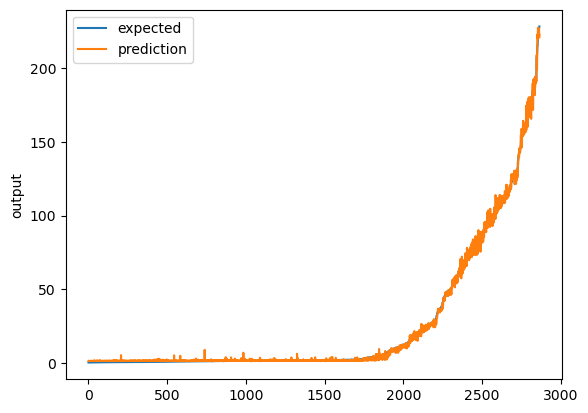

In [169]:
from sklearn import metrics
y_pred = model.predict(x_test)
print(y_pred.shape)
#rmse score
score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Score (RMSE): {}".format(score))
chart_regression(y_pred.flatten(),y_test, sort = True)